# Predicting Cancer Malignancy with a 2 layer neural network coded from scratch in Python.


**This notebook holds the Python code connected to this 3 part article:**

**<a href="https://towardsdatascience.com/the-keys-of-deep-learning-in-100-lines-of-code-907398c76504" target="_blank">Part 1</a> | <a href="https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2" target="_blank">Part 2</a> | <a href="https://medium.com/predicting-breast-cancer-tumors-with-your-own-neural-network-76271a05e941" target="_blank">Part 3</a>**<br>

It is adapted from the author's Github repo <a href="https://github.com/javismiles/Deep-Learning-predicting-breast-cancer-tumor-malignancy.git">here</a>.<br>

**With this code and the associated articles, you are going to:**
- Create a neural network from scratch in Python. Train it using the gradient descent algorithm.
- Apply that basic network to The Wisconsin Cancer Data-set. Predict if a tumor is benign or malignant, based on 9 different features.
- Explore deeply how back-propagation and gradient descent work.
- Review the basics and explore advanced concepts. 





In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

**The Dlnet 2 layer neural network class**

A 2 layer neural network class with gradient descent in less than 100 lines of code

In [5]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

class dlnet:
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [9, 15, 1] 
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        self.threshold=0.5
        
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return 

    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2

        self.Yh=A2
        loss=self.nloss(A2)
        return self.Yh, loss

    def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss

    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    
        
        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        
        return


    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return 


# Prepare the data
**Get the data from this link:**<br>
<a href="https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data" target="_blank">Wisconsin Cancer Dataset</a><br>

* Store the data in .csv format in your machine or online
* Read the data using Pandas read_csv function
* Then we proceed to clean and prepare the data, build our datasets and run gradient descent.

In [6]:
df = pd.read_csv('wisconsin-cancer-dataset.csv',header=None)
df = df[~df[6].isin(['?'])]
df = df.astype(float)
df.iloc[:,10].replace(2, 0,inplace=True)
df.iloc[:,10].replace(4, 1,inplace=True)

df.head(3)
scaled_df=df
names = df.columns[0:10]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,0:10]) 
scaled_df = pd.DataFrame(scaled_df, columns=names)


In [7]:
x=scaled_df.iloc[0:500,1:10].values.transpose()
y=df.iloc[0:500,10:].values.transpose()

xval=scaled_df.iloc[501:683,1:10].values.transpose()
yval=df.iloc[501:683,10:].values.transpose()

print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

nn = dlnet(x,y)
nn.lr=0.07
nn.dims = [9, 15, 1] 

(683, 11) (9, 500) (1, 500) (9, 182) (1, 182)


Cost after iteration 0: 0.673967
Cost after iteration 500: 0.122093
Cost after iteration 1000: 0.108469
Cost after iteration 1500: 0.103673
Cost after iteration 2000: 0.100911
Cost after iteration 2500: 0.099047
Cost after iteration 3000: 0.097530
Cost after iteration 3500: 0.096368
Cost after iteration 4000: 0.095480
Cost after iteration 4500: 0.094744
Cost after iteration 5000: 0.094015
Cost after iteration 5500: 0.093277
Cost after iteration 6000: 0.092611
Cost after iteration 6500: 0.091953
Cost after iteration 7000: 0.091279
Cost after iteration 7500: 0.090472
Cost after iteration 8000: 0.089574
Cost after iteration 8500: 0.088575
Cost after iteration 9000: 0.087426
Cost after iteration 9500: 0.086303
Cost after iteration 10000: 0.085122
Cost after iteration 10500: 0.084010
Cost after iteration 11000: 0.083025
Cost after iteration 11500: 0.082001
Cost after iteration 12000: 0.080948
Cost after iteration 12500: 0.079923
Cost after iteration 13000: 0.078909
Cost after iteration 1350

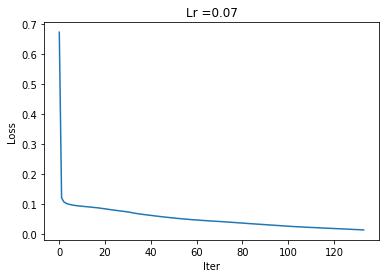

In [8]:
nn.gd(x, y, iter = 67000)

In [9]:
pred_train = nn.pred(x, y)
pred_test = nn.pred(xval, yval)

Acc: 1.0000000000000004
Acc: 0.9945054945054945


Acc: 1.0000000000000004


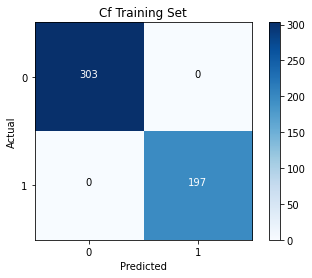

Acc: 0.9945054945054945


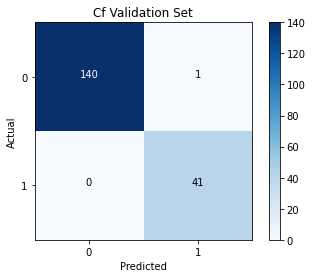

In [13]:
def plot(nn, threshold=0.5):
    nn.threshold=threshold

    nn.X,nn.Y=x, y 
    target=np.around(np.squeeze(y), decimals=0).astype(int)
    predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(int)
    plotCf(target,predicted,'Cf Training Set')

    nn.X,nn.Y=xval, yval 
    target=np.around(np.squeeze(yval), decimals=0).astype(int)
    predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(int)
    plotCf(target,predicted,'Cf Validation Set')
plot(nn, 0.5)

Acc: 0.9960000000000003


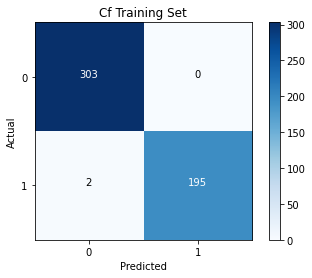

Acc: 0.9945054945054945


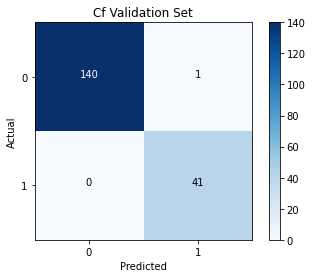

In [14]:
plot(nn, 0.7)

Acc: 0.9840000000000003


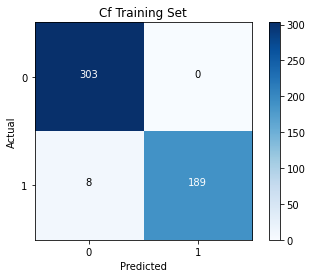

Acc: 0.9945054945054945


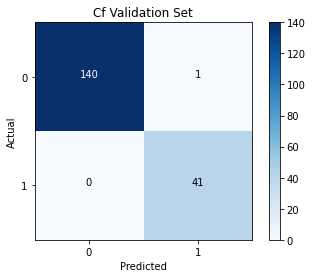

In [15]:
plot(nn, 0.9)

In [16]:
nn.X,nn.Y=xval, yval 
yvalh, loss = nn.forward()
print("\ny",np.around(yval[:,0:50,], decimals=0).astype(int))       
print("\nyh",np.around(yvalh[:,0:50,], decimals=0).astype(int),"\n")         


y [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

yh [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 

